In [258]:
import pandas as pd
#read the file
print("Hello")
df = pd.read_csv("./data.csv", index_col="index")
print(df.head())


Hello
              host       time method                           url  response  \
index                                                                          
0      ***.novo.dk  805465029    GET                     /ksc.html       200   
1      ***.novo.dk  805465031    GET    /images/ksclogo-medium.gif       200   
2      ***.novo.dk  805465051    GET  /images/MOSAIC-logosmall.gif       200   
3      ***.novo.dk  805465053    GET     /images/USA-logosmall.gif       200   
4      ***.novo.dk  805465054    GET    /images/NASA-logosmall.gif       200   

       bytes  
index         
0       7067  
1       5866  
2        363  
3        234  
4        786  


In [259]:
# removing all not needed GET requests
remove_media = df[
    df.url.str.contains(".html", case=False) & df.url.str.contains(".htm", case=False)
    | df.url.str.endswith("/")
]


In [260]:
#grouping by host (client user)
grouped_by_host = remove_media.groupby(by=["host"])
print(len(grouped_by_host))
# more_than_one_site = grouped_by_host.filter(lambda x: len(x) == 1)
#removing session with only one action
more_than_one_site = grouped_by_host.filter(lambda x: len(x) > 1)
print(len(more_than_one_site.groupby(by=["host"])))


33805
21656


In [261]:
grouped_more_action = more_than_one_site.groupby(by=["host"])
# print(len(grouped_more_action.groups))
# grouped_more_action.head()
divided_by_diff = grouped_more_action["time"].transform(lambda x: x.diff(), ).fillna(0)
more_than_one_site["difference"] = divided_by_diff


In [262]:
grouped_with_diff = more_than_one_site.groupby(by=["host"])
more_than_one_site["average"] = grouped_with_diff["difference"].transform(lambda x: (x.expanding().mean() ))
more_than_one_site.head(15)

,host,time,method,url,response,bytes,difference,average
index,,,,,,,,
0,***.novo.dk,805465029,GET,/ksc.html,200,7067,0.0,0.000000
6,***.novo.dk,805465068,GET,/shuttle/missions/missions.html,200,8678,39.0,19.500000
12,***.novo.dk,805465381,GET,/shuttle/resources/orbiters/columbia.html,200,6922,313.0,117.333333
13,***.novo.dk,807951768,GET,/shuttle/missions/sts-69/mission-sts-69.html,200,11264,2486387.0,621684.750000
18,***.novo.dk,807951832,GET,/shuttle/countdown/,200,4673,64.0,497360.600000
23,***.novo.dk,807951938,GET,/shuttle/countdown/liftoff.html,200,4665,106.0,414484.833333
26,***.novo.dk,807952060,GET,/shuttle/countdown/lps/fr.html,200,1879,122.0,355290.142857
37,007.thegap.com,805065755,GET,/shuttle/countdown/,200,3998,0.0,0.000000
41,007.thegap.com,805065868,GET,/shuttle/missions/sts-71/mission-sts-71.html,200,12722,113.0,56.500000


In [263]:
grouped_with_diff = more_than_one_site.groupby(by=["host"])
more_than_one_site["session_change"] = [
    True if diff > avg else False
    for diff, avg in zip(
        more_than_one_site["difference"], more_than_one_site["average"]
    )
]
more_than_one_site.head(25)


,host,time,method,url,response,bytes,difference,average,session
index,,,,,,,,,
0,***.novo.dk,805465029,GET,/ksc.html,200,7067,0.0,0.000000,False
6,***.novo.dk,805465068,GET,/shuttle/missions/missions.html,200,8678,39.0,19.500000,True
12,***.novo.dk,805465381,GET,/shuttle/resources/orbiters/columbia.html,200,6922,313.0,117.333333,True
13,***.novo.dk,807951768,GET,/shuttle/missions/sts-69/mission-sts-69.html,200,11264,2486387.0,621684.750000,True
18,***.novo.dk,807951832,GET,/shuttle/countdown/,200,4673,64.0,497360.600000,False
23,***.novo.dk,807951938,GET,/shuttle/countdown/liftoff.html,200,4665,106.0,414484.833333,False
26,***.novo.dk,807952060,GET,/shuttle/countdown/lps/fr.html,200,1879,122.0,355290.142857,False
37,007.thegap.com,805065755,GET,/shuttle/countdown/,200,3998,0.0,0.000000,False
41,007.thegap.com,805065868,GET,/shuttle/missions/sts-71/mission-sts-71.html,200,12722,113.0,56.500000,True


In [279]:
from skmultiflow.drift_detection import PageHinkley, HDDM_A,HDDM_W
errors = []

for _,group in grouped_with_diff:
    detector = HDDM_A()
    for current, previous in zip(group["difference"], group["difference"].shift(1)):
        detector.add_element(current)
        
        if detector.detected_change() or detector.detected_warning_zone():
            if current > previous and int(previous) != 0:
                errors.append(True)
            else:
                errors.append(False)
        else:
            errors.append(False)

more_than_one_site["session_intel_change"] = errors
more_than_one_site.head()

,host,time,method,url,response,bytes,difference,average,session,session_intel,correct_session
index,,,,,,,,,,,
0,***.novo.dk,805465029,GET,/ksc.html,200,7067,0.0,0.000000,False,False,False
6,***.novo.dk,805465068,GET,/shuttle/missions/missions.html,200,8678,39.0,19.500000,True,False,False
12,***.novo.dk,805465381,GET,/shuttle/resources/orbiters/columbia.html,200,6922,313.0,117.333333,True,False,False
13,***.novo.dk,807951768,GET,/shuttle/missions/sts-69/mission-sts-69.html,200,11264,2486387.0,621684.750000,True,True,True
18,***.novo.dk,807951832,GET,/shuttle/countdown/,200,4673,64.0,497360.600000,False,False,False


<AxesSubplot:xlabel='index'>

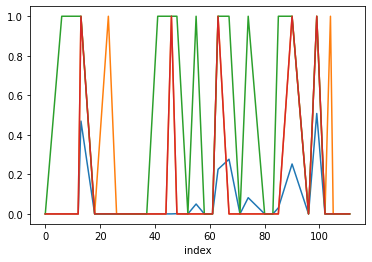

In [283]:
(more_than_one_site["difference"]/more_than_one_site["difference"].max()).head(30).plot()
more_than_one_site["session_intel_change"].head(30).astype(int).plot()
more_than_one_site["session_change"].head(30).astype(int).plot()

more_than_one_site["correct_session_change"] = (more_than_one_site["session_intel_change"].apply(int) + more_than_one_site["session_change"].apply(int) ) >1
more_than_one_site["correct_session_change"].head(30).astype(int).plot()



In [284]:
more_than_one_site.head(30)

,host,time,method,url,response,bytes,difference,average,session,session_intel,correct_session
index,,,,,,,,,,,
0,***.novo.dk,805465029,GET,/ksc.html,200,7067,0.0,0.000000,False,False,False
6,***.novo.dk,805465068,GET,/shuttle/missions/missions.html,200,8678,39.0,19.500000,True,False,False
12,***.novo.dk,805465381,GET,/shuttle/resources/orbiters/columbia.html,200,6922,313.0,117.333333,True,False,False
13,***.novo.dk,807951768,GET,/shuttle/missions/sts-69/mission-sts-69.html,200,11264,2486387.0,621684.750000,True,True,True
18,***.novo.dk,807951832,GET,/shuttle/countdown/,200,4673,64.0,497360.600000,False,False,False
23,***.novo.dk,807951938,GET,/shuttle/countdown/liftoff.html,200,4665,106.0,414484.833333,False,True,False
26,***.novo.dk,807952060,GET,/shuttle/countdown/lps/fr.html,200,1879,122.0,355290.142857,False,False,False
37,007.thegap.com,805065755,GET,/shuttle/countdown/,200,3998,0.0,0.000000,False,False,False
41,007.thegap.com,805065868,GET,/shuttle/missions/sts-71/mission-sts-71.html,200,12722,113.0,56.500000,True,False,False
